# Titanic Survival Classification - More Advanced Models (Part 3)

After building a simple logistic regression classifier it appears our data may need a more advanced function to fit than can be derived by a logistic regression unit alone.  

So lets experiment with seeing how some popular algorithms perform.  

To give credit this notebook is based upon - https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python?scriptVersionId=2368078 so credit to the author, I simply want to see how each of those models perform individually.

For this project I will use SciKit Learn as a primary library.

In [34]:
#Importing packages and data
#First importing some relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Import the functions built in Parts 1 and 2
from Titanic_Import import *

full_set = pd.read_csv('D:/Datasets/Titanic/train.csv')

#import data we cleansed last time
X_Train, X_CV, Y_Train, Y_CV = Cleanse_Training_Data(full_set)


Now to import our frameworks

In [35]:
import sklearn as sk
from sklearn import svm


## Support Vector Machine
So to get started lets see the performance of a Support Vector Machine.  For our implementation we're going to use SciKit Learn's implementation of an SVM to see the performance and also to get a feel for how SciKit Learn performs as a package having never used it until now.

So first lets train a simple SVM on our training data.


In [86]:
#Instanciate a SVM object
clf = svm.SVC(kernel='linear')
#Train the SVM
clf.fit(X_Train, Y_Train)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Now we have our SVM (with a linear kernel) trained lets see how it performs

In [36]:
#Get our Training Data Predictions
y_hat_svm = clf.predict(X_Train)

acc1, score1, conf1 = Calc_Accuracy(Y_Train, y_hat_svm)

print("Accuracy = ", acc1)
print("F1 Score = ", score1)
print("")
print("Confusion Matrix")
conf1[["Labels", "Actual True", "Actual False"]]

Accuracy =  79.14032869785082
F1 Score =  0.7254575707154742

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,218,77
1,Pred False,88,408


And the performance on Cross Validation Data is 

In [37]:
y_hat_svm_CV = clf.predict(X_CV)

acc2, score2, conf2 = Calc_Accuracy(Y_CV, y_hat_svm_CV)

print("Accuracy = ", acc2)
print("F1 Score = ", score2)
print("")
print("Confusion Matrix")
conf2[["Labels", "Actual True", "Actual False"]]

Accuracy =  78.0
F1 Score =  0.6944444444444444

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,25,11
1,Pred False,11,53


So we have approximately the same performance on a SVM with a linear kernel as we do with our logistic regression unit.  This confirms that we need either some feature manipulation or a more advanced function to fit our data.

So let's try some different kernels and see below for the best Kernel I could come up with.

In [108]:
clf_2 = svm.SVC(kernel= 'rbf')

clf_2.fit(X_Train, Y_Train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
#Get our Training Data Predictions
y_hat_svm2 = clf_2.predict(X_Train)

acc3, score3, conf3 = Calc_Accuracy(Y_Train, y_hat_svm2)

print("Accuracy = ", acc3)
print("F1 Score = ", score3)
print("")
print("Confusion Matrix")
conf3[["Labels", "Actual True", "Actual False"]]

Accuracy =  80.40455120101137
F1 Score =  0.7266313932980599

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,206,55
1,Pred False,100,430


In [38]:
y_hat_svm_CV2 = clf_2.predict(X_CV)

acc2, score2, conf2 = Calc_Accuracy(Y_CV, y_hat_svm_CV2)

print("Accuracy = ", acc2)
print("F1 Score = ", score2)
print("")
print("Confusion Matrix")
conf2[["Labels", "Actual True", "Actual False"]]

Accuracy =  81.0
F1 Score =  0.7164179104477612

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,24,7
1,Pred False,12,57


So even a SVM with a gaussian kernel can about match the performance of our logistic regression unit.  So before building the next model let's revisit our data and perform some outlier analysis that could potentially be skewing our data.

# Outlier Analysis

So we're going to build a simple anomaly detection system to do this using our training data.

In [65]:
#Building Anomaly Detector
def anomaly_detector_build(X_Train) :
    m, n = X_Train.shape
    mu = np.sum(X_Train, axis=0) / m
    sigma = np.matmul((X_Train - mu).T, (X_Train - mu)) / m
    
    sig_det = np.linalg.det(sigma)
    return sig_det

test = anomaly_detector(X_Train)
print(test)

0.0


However in the process of building our outlier analysis system it appears that our sigma matrix is non-invertible due to having a determinant of zero, likely as a result of having so many one-hot features and having normalized our primary numeric variables about zero and normalized the variances also. 

So to save time lets use one a system from the SciKit Learn framework - the Scikit learn Isolation Forest looks like a solid system for high dimensional outlier analysis so lets give it a go.

In [67]:
from sklearn.ensemble import IsolationForest
anom_f = IsolationForest(contamination = 0.001)
anom_f.fit(X_Train)

X_Train_outliers = anom_f.predict(X_Train)

In [75]:
np.where(X_Train_outliers != 1)

(array([311, 742], dtype=int64),)

So we have 2 outliers in our training set, as our passengerID is the same as its position + 1 we know they are passengerIDs 312 and 743.  So first lets print out our first 10 observations as a benchmark.

In [76]:
full_set.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,canc,Deckstr,Norm_age,Norm_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN,-0.096747,-0.048707
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C85,C,0.104309,0.076277
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN,-0.046483,-0.047390
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C123,C,0.066611,0.040786
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN,0.066611,-0.047146
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,NaN,NaN,0.000000,-0.046349
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E46,E,0.305364,0.038370
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,NaN,NaN,-0.348066,-0.021723
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,NaN,NaN,-0.033917,-0.041128
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,NaN,NaN,-0.197275,-0.004164


In [94]:
full_set[full_set['PassengerId'] == 312]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,canc,Deckstr,Norm_age,Norm_fare
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,B57B59B63B66,B,-0.147011,0.449263


In [95]:
full_set[full_set['PassengerId'] == 743]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,canc,Deckstr,Norm_age,Norm_fare
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,B57B59B63B66,B,-0.109313,0.449263


So our two 'anomalies' are two seemingly wealthy young women, likely sisters judging by the fact they have 4 cabins between 2 people and they have the same Ticket reference.  So I would say these two datapoints are not actually particularly anomalous as they would indeed be likely to survive due to being likely very high in the social hierachy. 

The likely reason for the anomalies being flagged is due to having a very high fare.

Hence I will not remove them from our training data however clipping the fare value may be an option to consider to help the normalization.  For now I will leave them as is.

# Trying some different models

So SciKit learn has a few different classifiers, so lets see if any of the other classifiers have any better performance so we may add them into our final ensemble model.

So models to test are -
* Random Forest Classifier
* AdaBoost Classifier
* Extra Trees Classifier
* Gradient Boosting Classifier


## Random Forest

In [40]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 2000,
     'warm_start': False, 
     #'max_features': 0.2,
    'max_depth': 300,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

clf_3 = RandomForestClassifier(**rf_params)

clf_3.fit(X_Train, Y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=300, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
#Get our Training Data Predictions
y_hat_rf = clf_3.predict(X_Train)

acc4, score4, conf4 = Calc_Accuracy(Y_Train, y_hat_rf)

print("Accuracy = ", acc4)
print("F1 Score = ", score4)
print("")
print("Confusion Matrix")
conf4[["Labels", "Actual True", "Actual False"]]

Accuracy =  90.13906447534767
F1 Score =  0.8645833333333334

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,249,21
1,Pred False,57,464


In [42]:
#Get our Cross Validation Data Predictions
y_hat_rfCV = clf_3.predict(X_CV)

acc5, score5, conf5 = Calc_Accuracy(Y_CV, y_hat_rfCV)

print("Accuracy = ", acc5)
print("F1 Score = ", score5)
print("")
print("Confusion Matrix")
conf5[["Labels", "Actual True", "Actual False"]]

Accuracy =  84.0
F1 Score =  0.7647058823529411

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,26,6
1,Pred False,10,58


So the Random Forest Classifier is our best classifier yet and outperforms both logistic regression and the SVM.  This is a promising start.  Also one nice thing about SciKit Learn that I have just discovered is that it can output feature importances.

In [43]:
clf_test = RandomForestClassifier(**rf_params)

test = clf_test.fit(X_Train, Y_Train).feature_importances_

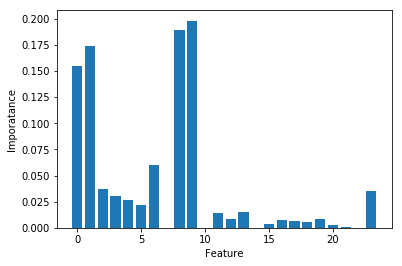

In [44]:
bar = np.ones(24)
for i in range(24):
    bar[i] = i
    
plt.bar(bar, test)
plt.ylabel('Imporatance')
plt.xlabel('Feature')
plt.show()


As we decided to encode our features into a series of one hot vectors this means this particular plot isn't too useful, however it does show that the age and fare are of moderate importance, as is if someone was in the 3rd class, however features 8 and 9 (one hot vectors for Gender) are of extreme importance.  And if someone had a deck or not also seems of moderate importance (feature 24).

Kind of interesting but I think this would have been much more useful if we had not encoded our data.

Also one thing to note is that this model has overfit our training set slightly due to the 5% gap between the cross validation and training set accuracies, however given that this is our best performance yet on the cross validation set this overfitting is acceptable, and should be counteracted when the full ensemble is constructed.

## Ada Boost

In [45]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 5000,
    'learning_rate' : 0.75
}

adaboost = AdaBoostClassifier(**ada_params)

adaboost.fit(X_Train, Y_Train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.75, n_estimators=5000, random_state=None)

In [46]:
#Get our Training Data Predictions
y_hat_ada = adaboost.predict(X_Train)

acc5, score5, conf5 = Calc_Accuracy(Y_Train, y_hat_ada)

print("Accuracy = ", acc5)
print("F1 Score = ", score5)
print("")
print("Confusion Matrix")
conf5[["Labels", "Actual True", "Actual False"]]

Accuracy =  90.77117572692795
F1 Score =  0.8768971332209106

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,260,27
1,Pred False,46,458


In [47]:
#Get our Cross Validation Data Predictions
y_hat_adacv = adaboost.predict(X_CV)

acc6, score6, conf6 = Calc_Accuracy(Y_CV, y_hat_adacv)

print("Accuracy = ", acc6)
print("F1 Score = ", score6)
print("")
print("Confusion Matrix")
conf6[["Labels", "Actual True", "Actual False"]]

Accuracy =  82.0
F1 Score =  0.7567567567567567

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,28,10
1,Pred False,8,54


So Adaboost seems to be decent but has overfit our data to a much greater degree than Random Forest.
## Extra Trees

In [48]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
    #'max_features': 0.5,
    'max_depth': 32,
    'min_samples_leaf': 2,
    'verbose': 0
}

extrees = ExtraTreesClassifier(**et_params)

extrees.fit(X_Train, Y_Train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=32, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [49]:
#Get our Training Data Predictions
y_hat_ext = extrees.predict(X_Train)

acc6, score6, conf6 = Calc_Accuracy(Y_Train, y_hat_ext)

print("Accuracy = ", acc6)
print("F1 Score = ", score6)
print("")
print("Confusion Matrix")
conf6[["Labels", "Actual True", "Actual False"]]

Accuracy =  88.24273072060683
F1 Score =  0.8330341113105925

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,232,19
1,Pred False,74,466


In [50]:
#Get our Cross Validation Data Predictions
y_hat_extcv = extrees.predict(X_CV)

acc7, score7, conf7 = Calc_Accuracy(Y_CV, y_hat_extcv)

print("Accuracy = ", acc7)
print("F1 Score = ", score7)
print("")
print("Confusion Matrix")
conf7[["Labels", "Actual True", "Actual False"]]

Accuracy =  83.0
F1 Score =  0.746268656716418

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,25,6
1,Pred False,11,58


So Extra Trees is performing approximately on par with our previous classifiers but is slightly less prone to overfitting.
## Gradient Boosting

In [51]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'learning_rate' : 0.05,
    'max_depth': None,
    'min_samples_leaf': 2,
    'verbose': 0
}

gbc = GradientBoostingClassifier(**gb_params)

gbc.fit(X_Train, Y_Train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
#Get our Training Data Predictions
y_hat_gb = gbc.predict(X_Train)

acc7, score7, conf7 = Calc_Accuracy(Y_Train, y_hat_gb)

print("Accuracy = ", acc7)
print("F1 Score = ", score7)
print("")
print("Confusion Matrix")
conf7[["Labels", "Actual True", "Actual False"]]

Accuracy =  98.73577749683943
F1 Score =  0.9837662337662337

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,303,7
1,Pred False,3,478


In [53]:
#Get our Cross Validation Data Predictions
y_hat_gbcv = gbc.predict(X_CV)

acc8, score8, conf8 = Calc_Accuracy(Y_CV, y_hat_gbcv)

print("Accuracy = ", acc8)
print("F1 Score = ", score8)
print("")
print("Confusion Matrix")
conf8[["Labels", "Actual True", "Actual False"]]

Accuracy =  85.0
F1 Score =  0.7945205479452055

Confusion Matrix


,Labels,Actual True,Actual False
0,Pred True,29,8
1,Pred False,7,56


So Gradient boosting is extremely prone to overfitting but also extremely good at fitting our training data.  

## Conclusion

After looking at a few models from SciKit Learn it appears they are mostly very simple and easy to use and generally quite good at fitting the data.  However this comes at a price - they are somewhat difficult to regularize and thus are prone to overfitting. 

I suspect that this particular quirk can be somewhat counteracted by using an ensemble of a couple of different models and training a seperate simple classifier on all of the outputs to better fit on more general data.

The next step is to try out a neural network as a classifier and see how that performs and build our final ensemble.

Part 4 to follow.